In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words
from sklearn.decomposition import PCA
from sklearn.cluster import *
from sklearn.mixture import *
from umap import UMAP
from collections import Counter
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.base import clone as clone_estimator
import re
from scipy.spatial.distance import pdist, squareform, cosine, euclidean

## Define some usefull functions

In [2]:
def aggregate_by_label(df: pd.DataFrame, label: str, min_threshold: int = 0):

    top_labels = df[label].value_counts()[df[label].value_counts() > min_threshold]
    
    entries = []
    for l in top_labels.index:
        label_df = df[df[label] == l]
        all_texts = []
        for text in label_df.text:
            all_texts.append(text)
        entry = {}
        
        conctanated_text = " ".join(all_texts)
        entry['label'] = l
        entry['text'] = conctanated_text
        entry['n_texts'] = len(all_texts)
        entry['n_tokens'] = len(conctanated_text.split())
        entry['instances'] = ", ".join(label_df.filename.to_list())
        
        entries.append(entry)
    return pd.DataFrame.from_records(entries)

In [3]:
def get_cluster_dfs(df, cluster):
    "Get one df with all entries from one cluster for all clusters"
    return [df[cluster == i] for i in np.unique(cluster)]

In [4]:
from plotly.colors import qualitative 

def plotly_color_categorical_values(values, cmap=qualitative.Light24):
    uniq = np.unique(values)
    if len(uniq) > len(cmap):
        print("Need more colors than current cmap holds")
        return
    categories_color = {cat: cmap[index] for index, cat in enumerate(uniq)}
    return [categories_color[cat] for cat in values]

In [5]:
from sklearn.model_selection import ParameterGrid
from sklearn.base import ClusterMixin
from tqdm import tqdm
from sklearn.base import clone as clone_estimator
from time import time

def _call_scoring(entry, score, data):
    try:
        entry[score.__name__] = score(data)
    except Exception as e:
        entry['Exception'] = e
    return entry

def tune(clu: ClusterMixin,
         X: np.ndarray,
         params: ParameterGrid,
         scoring: callable = None,
         verbose: bool = True):
    
    results = []
    params = tqdm(params) if verbose else params
    for param_comb in params:
        entry = {**param_comb}
        clu_instance = clone_estimator(clu)
        
        fit_start = time()
        clu_instance.fit(X)
        fit_time = time() - fit_start
        entry['fit_time'] = fit_time
        
        labels = clu_instance.predict(X)
        
        if scoring:
            if isinstance(scoring, list):
                for score in scoring:
                    _call_scoring(entry=entry, score=score, data=labels)
            if callable(scoring):
                _call_scoring(entry=entry, score=scoring, data=labels)
            else:
                raise Exception('Invalid scoring parameter passed')
        else:
            if hasattr(clu_instance, 'score') and callable(clu_instance.score):
                _call_scoring(entry=entry, score=clu_instance.score, data=X)
        results.append(entry)
        
    return pd.DataFrame.from_records(results)

In [6]:
class DenseTransformer(TransformerMixin):
    """
    Transformer for convert sparse data into dense.
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.todense()

In [7]:
def merge_params_dicts(*args, sep='__'):
    """
    Merges n python dicts into one.
    If each dict is passed in a tuple where the first entry is a string,
    all keys in that dict will get the string as prefix
    """
    merged = {}
    for entry in args:
        if isinstance(entry, tuple):
            prefix = entry[0]
            merged.update({prefix + sep + key: value for key, value in entry[1].items()})
        if isinstance(entry, dict):
            merged.update(entry)
    return merged

In [8]:
def print_clusters(dfs):
    for index, cluster_df in enumerate(dfs):
        print(f'Cluster {index}')
        print(cluster_df.label)
        print(f'Total number of movies in cluster => {cluster_df.n_texts.sum()}')
        print(f'Total number of tokens in cluster => {cluster_df.n_tokens.sum()}')
        print('#'*60)

In [9]:
def cluster_distribution(cluster):
    cluster_counter = Counter(cluster)
    plt.bar(cluster_counter.keys(), cluster_counter.values())
    plt.show()
    return cluster_counter

## Load dataset

In [10]:
df = pd.read_csv('../dataset/movies_complete.csv')
df.dropna(subset=['genre'], inplace=True)
df['text_length'] = df.text.apply(lambda x: len(x.split()))
df = df[df['text_length'] >= 3000]

## Aggregate texts by Language attribute
We set the threshold to 1, every Language entry which occurs only one time is discarded

In [11]:
aggr = aggregate_by_label(df, 'Language', 3)

We compute the number of different languages (that occur alone at least one time in our aggregated dataset)
We will use this number as number of cluster later on.

In [12]:
single_labels = aggr.label[aggr.label.str.split(',').apply(lambda x: len(x)) == 1]
n_single_labels = len(single_labels)
single_labels, n_single_labels

(0          English
 1           French
 2           German
 3         Japanese
 5          Spanish
 6           Korean
 8          Turkish
 10        Mandarin
 14       Norwegian
 15          Danish
 16           Dutch
 18         Swedish
 19         Russian
 20         Italian
 21       Icelandic
 24       Cantonese
 25            Thai
 26           Hindi
 29      Portuguese
 41         Chinese
 42           Greek
 49          Polish
 52    Swiss German
 60          Arabic
 63        Romanian
 Name: label, dtype: object,
 25)

## Define feature extraction pipeline(s)

In [97]:
feature_pipe = make_pipeline(
    
    TfidfVectorizer(
        #stop_words=get_stop_words('de'),
        max_features=100,
        ngram_range=(1,1)),
    
    DenseTransformer(),
    
    UMAP(n_components=20,
         random_state=42),
)
feature_pipe

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=100)),
                ('densetransformer',
                 <__main__.DenseTransformer object at 0x7fc61065d850>),
                ('umap', UMAP(n_components=20, random_state=42))])

In [98]:
X = feature_pipe.fit_transform(aggr.text)

In [99]:
feature_pipe[0].vocabulary_

{'die': 23,
 'also': 4,
 'das': 16,
 'der': 21,
 'in': 48,
 'den': 19,
 'und': 84,
 'haben': 38,
 'vor': 87,
 'sie': 80,
 'dass': 17,
 'es': 31,
 'eine': 28,
 'so': 82,
 'nur': 72,
 'wenn': 91,
 'einen': 29,
 'wird': 97,
 'von': 86,
 'mit': 65,
 'dem': 18,
 'ist': 49,
 'ihn': 44,
 'kann': 52,
 'mir': 64,
 'zu': 99,
 'als': 3,
 'was': 89,
 'schon': 76,
 'aber': 0,
 'nicht': 69,
 'werden': 92,
 'keine': 53,
 'hat': 40,
 'ja': 50,
 'an': 5,
 'uns': 85,
 'auf': 7,
 'wo': 98,
 'denn': 20,
 'für': 33,
 'aus': 8,
 'wir': 96,
 'bei': 9,
 'er': 30,
 'sich': 79,
 'noch': 71,
 'oder': 73,
 'man': 58,
 'doch': 25,
 'sein': 78,
 'um': 83,
 'wie': 93,
 'da': 13,
 'alles': 2,
 'sehr': 77,
 'im': 46,
 'war': 88,
 'auch': 6,
 'ihr': 45,
 'ein': 27,
 'alle': 1,
 'mehr': 60,
 'nichts': 70,
 'machen': 56,
 'dann': 15,
 'nach': 67,
 'gut': 35,
 'wieder': 94,
 'immer': 47,
 'sind': 81,
 'mal': 57,
 'hier': 42,
 'ich': 43,
 'muss': 66,
 'hab': 36,
 'jetzt': 51,
 'habe': 37,
 'mich': 63,
 'du': 26,
 'mann': 5

In [100]:
def filter_non_stopwords(s, stopwords=get_stop_words('de')):
    stopwords = set([t.lower() for t in stopwords])
    token = re.findall(r'\w+', s.lower())
    return " ".join([t for t in token if t in stopwords])

#only_stopwords = aggr.text.apply(filter_non_stopwords)

In [101]:
#len(get_stop_words('de'))

In [102]:
#Xstop = feature_pipe.fit_transform(only_stopwords)

In [103]:
#X = Xstop

In [104]:
X.shape

(65, 20)

## Compute 2D umap representation of our data
We use the same pipeline for computing 2D data for plotting our results

In [105]:
Xr = UMAP(n_components=2).fit_transform(X)
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=aggr.n_tokens))


fig.show()

# KMeans-Clustering

In [106]:
from yellowbrick.cluster import KElbowVisualizer

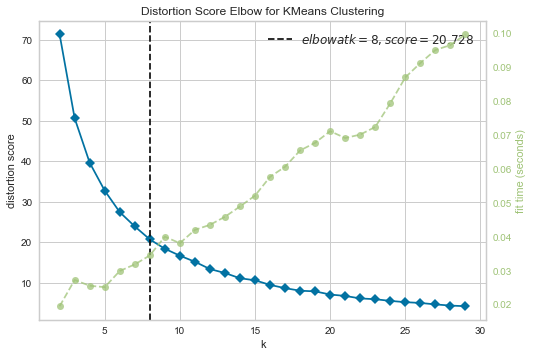

In [107]:
visualizer = KElbowVisualizer(KMeans(), k=(2, 30))
visualizer.fit(X)
visualizer.show()

In [108]:
kmeans = KMeans(n_clusters=8)
kmean_cluster = kmeans.fit_predict(X)
kmeans_dfs = get_cluster_dfs(aggr, kmean_cluster)

In [201]:
center_distances = squareform(pdist(kmeans.cluster_centers_, euclidean))

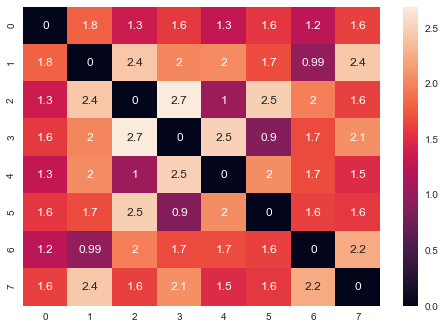

In [202]:
sns.heatmap(center_distances, annot=True)

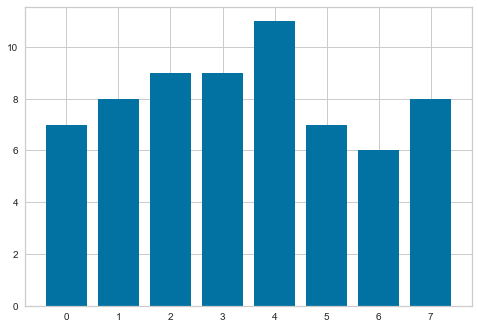

In [109]:
kmeans_cluster_counts = cluster_distribution(kmean_cluster)

In [110]:
kmeans_dfs[1].head()

,label,text,n_texts,n_tokens,instances
2,German,Hände hoch oder ich schieße ( 1966 ) dTV - MDR...,190,1676394,"4732286.xml, 3689777.xml, 3587552.xml, 3306117..."
11,"German, English",( Grillengezirpe ) ( Vogelschreie ) ( Dröhnen ...,29,243233,"4794472.xml, 5766111.xml, 5074196.xml, 4421004..."
14,Norwegian,"Ich weiß nicht , wann es begann , oder wie es ...",23,147740,"4903811.xml, 5862471.xml, 4918401.xml, 4413003..."
16,Dutch,Zieh deine Socken aus . Und deine Hose . T-Shi...,21,156794,"5505476.xml, 4464865.xml, 6809239.xml, 4535696..."
18,Swedish,"PATRIK , AGE 1 / 5 Basierend auf einem Stück v...",18,136157,"3592485.xml, 4887280.xml, 5252151.xml, 3855929..."


In [203]:
print_clusters(kmeans_dfs)

Cluster 0
5                     Spanish
30           Spanish, English
40             French, Arabic
45           English, Chinese
46             English, Latin
58             Arabic, French
62    English, Arabic, Hebrew
Name: label, dtype: object
Total number of movies in cluster => 105
Total number of tokens in cluster => 771479
############################################################
Cluster 1
2              German
11    German, English
14          Norwegian
16              Dutch
18            Swedish
21          Icelandic
36    German, Turkish
52       Swiss German
Name: label, dtype: object
Total number of movies in cluster => 308
Total number of tokens in cluster => 2534316
############################################################
Cluster 2
1                       French
7              English, French
9              French, English
22            English, Italian
33              French, German
38    English, French, Italian
48             French, Italian
54             Frenc

In [112]:
kmeans_dbscore = davies_bouldin_score(X, kmean_cluster)
kmeans_dbscore

1.028114057776006

In [113]:
kmeans_chscore = calinski_harabasz_score(X, kmean_cluster)
kmeans_chscore

38.58115557315378

# DBSCAN-Clustering

In order to find a suitable value for the min-distance parameter ```eps``` we compute the mean distance between all datatpoints

In [183]:
from scipy.spatial.distance import pdist, squareform, cosine, euclidean
dm = squareform(pdist(X, cosine))

In [184]:
dm

array([[0.        , 0.0008413 , 0.00317856, ..., 0.00215479, 0.0021569 ,
        0.0009723 ],
       [0.0008413 , 0.        , 0.00370211, ..., 0.00212078, 0.00259437,
        0.00015044],
       [0.00317856, 0.00370211, 0.        , ..., 0.00267261, 0.00212328,
        0.00441996],
       ...,
       [0.00215479, 0.00212078, 0.00267261, ..., 0.        , 0.00094757,
        0.00240341],
       [0.0021569 , 0.00259437, 0.00212328, ..., 0.00094757, 0.        ,
        0.00284216],
       [0.0009723 , 0.00015044, 0.00441996, ..., 0.00240341, 0.00284216,
        0.        ]])

In [185]:
dm.mean()

0.0026174896763856504

Now we choose a value near the mean distance as eps and set the min_samples param for density reachability to a low value since we do not have many points in our dataset.

In [187]:
dbscan = DBSCAN(metric='cosine', eps=0.8, min_samples=3)

In [188]:
dbscan_cluster = dbscan.fit_predict(X)

In [189]:
dbscan_dfs = get_cluster_dfs(aggr, dbscan_cluster)

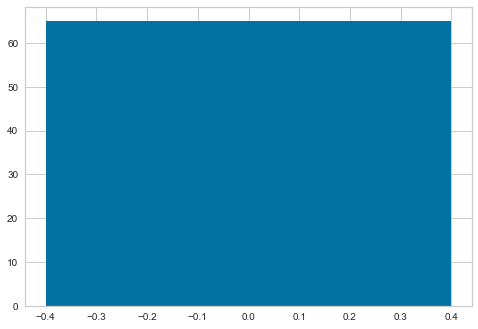

In [190]:
dbscan_cluster_counts = cluster_distribution(dbscan_cluster)

In [180]:
print(len(dbscan_cluster_counts))

4


=> The number data points marked as noise is surpringly low
=> The min_samples param has great influence on the number of clusters that the algorithm will find

In [181]:
noise = aggr[dbscan_cluster == -1]
noise

,label,text,n_texts,n_tokens,instances
44,"Norwegian, English",13. Oktober 2008 Erhalten von Filmkameratene A...,5,29945,"4089780.xml, 6674436.xml, 4816727.xml, 6483045..."
46,"English, Latin",Leaves of Grass ( 2009 ) dTV - Das Erste - 9. ...,5,42262,"4617134.xml, 4051224.xml, 4752606.xml, 4978559..."
55,"English, Italian, Spanish","Es gibt 2 Arten von Menschen auf dieser Welt ,...",4,38116,"3651521.xml, 4790478.xml, 5827249.xml, 6652468..."


In [182]:
print_clusters(dbscan_dfs)

Cluster 0
44           Norwegian, English
46               English, Latin
55    English, Italian, Spanish
Name: label, dtype: object
Total number of movies in cluster => 14
Total number of tokens in cluster => 110323
############################################################
Cluster 1
0                      English
1                       French
3                     Japanese
4             English, Spanish
5                      Spanish
6                       Korean
7              English, French
9              French, English
10                    Mandarin
12             English, German
13            English, Russian
15                      Danish
17           English, Japanese
19                     Russian
22            English, Italian
23          English, Ukrainian
24                   Cantonese
25                        Thai
26                       Hindi
27             English, Arabic
28           English, Mandarin
30            Spanish, English
31           Japanese, English

In [81]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[
                                    f'{label}|{n_texts}|{n_tokens}' for label, n_texts, n_tokens in zip(aggr.label, aggr.n_texts, aggr.n_tokens)
                                ],
                                marker_color=plotly_color_categorical_values(dbscan_cluster)))


fig.show()

Need more colors than current cmap holds


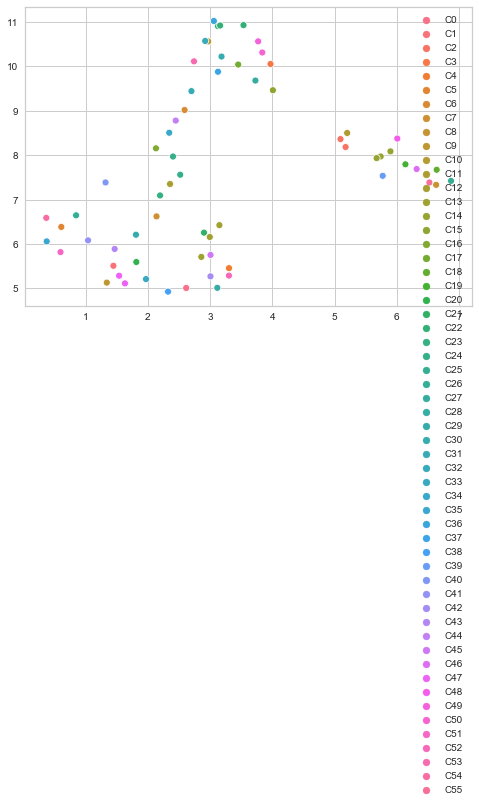

In [82]:
import seaborn as sns
sns.scatterplot(x=Xr[:, 0],
                y=Xr[:, 1],
               hue=[f'C{i}' for i in dbscan_cluster])

In [83]:
print_clusters(dbscan_dfs)

Cluster 0
0    English
Name: label, dtype: object
Total number of movies in cluster => 1382
Total number of tokens in cluster => 12181830
############################################################
Cluster 1
1    French
Name: label, dtype: object
Total number of movies in cluster => 204
Total number of tokens in cluster => 1589231
############################################################
Cluster 2
2     German
16     Dutch
Name: label, dtype: object
Total number of movies in cluster => 211
Total number of tokens in cluster => 1833188
############################################################
Cluster 3
3    Japanese
Name: label, dtype: object
Total number of movies in cluster => 100
Total number of tokens in cluster => 670914
############################################################
Cluster 4
4    English, Spanish
Name: label, dtype: object
Total number of movies in cluster => 78
Total number of tokens in cluster => 810080
#######################################################

In [84]:
if len(dbscan_cluster_counts) > 1:
    dbscan_dbscore = davies_bouldin_score(X, dbscan_cluster)
else:
    dbscan_dbscore = None
dbscan_dbscore

0.2656193849134325

In [85]:
if len(dbscan_cluster_counts) > 1:
    dbscan_chscore = calinski_harabasz_score(X, dbscan_cluster)
else:
    dbscan_chscore = None
dbscan_chscore

30.653607322002898

## GaussianMixtureModels Clustering

In [86]:
gmm = BayesianGaussianMixture(n_components=30)

In [87]:
gmm_cluster = gmm.fit_predict(X)


In [88]:
gmm.weights_.mean(), gmm.weights_.std()

(0.03333333333333334, 0.018164779514765327)

In [89]:
gmm_n_cluster = len(gmm.weights_[gmm.weights_ > 0.0333])

In [90]:
gmm = BayesianGaussianMixture(n_components=gmm_n_cluster)
gmm_cluster = gmm.fit_predict(X)
probs = gmm.predict_proba(X)

In [91]:
gmm_dfs = get_cluster_dfs(aggr, gmm_cluster)

gmm_cluster_counts = cluster_distribution(gmm_cluster)

In [92]:
fig = go.Figure(data=go.Scatter(x=Xr[:, 0],
                                y=Xr[:, 1],
                                mode='markers',
                                text=[f'{label}|{n_token}' for label, n_token in zip(aggr.label, aggr.n_texts)],
                                marker_color=plotly_color_categorical_values(gmm_cluster)))


fig.show()

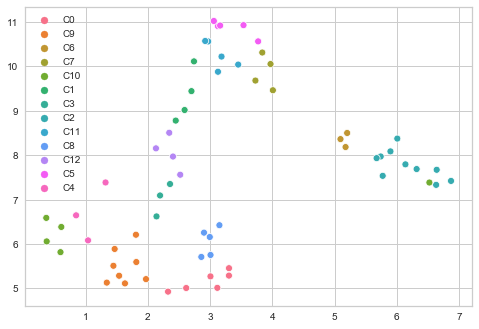

In [93]:
import seaborn as sns
sns.scatterplot(x=Xr[:, 0],
                y=Xr[:, 1],
               hue=[f'C{i}' for i in gmm_cluster])

In [94]:
print_clusters(gmm_dfs)

Cluster 0
0                 English
4        English, Spanish
32    English, Portuguese
43       Swedish, English
47        English, Hebrew
59          English, Thai
Name: label, dtype: object
Total number of movies in cluster => 1483
Total number of tokens in cluster => 13215845
############################################################
Cluster 1
6                  Korean
35     Cantonese, English
49                 Polish
61    Cantonese, Mandarin
Name: label, dtype: object
Total number of movies in cluster => 67
Total number of tokens in cluster => 493975
############################################################
Cluster 2
8                       Turkish
14                    Norwegian
18                      Swedish
20                      Italian
21                    Icelandic
29                   Portuguese
36              German, Turkish
44           Norwegian, English
52                 Swiss German
55    English, Italian, Spanish
Name: label, dtype: object
Total number of

In [95]:
gmm_dbscore = davies_bouldin_score(X, gmm_cluster)
gmm_dbscore

0.9074147943113752

In [96]:
gmm_chscore = calinski_harabasz_score(X, gmm_cluster)
gmm_chscore

32.19473314564718